In [1]:
# clone the repo
!git clone https://github.com/MedicineToken/Medical-SAM2.git

Cloning into 'Medical-SAM2'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 191 (delta 43), reused 36 (delta 36), pack-reused 136 (from 1)
Receiving objects: 100% (191/191), 2.20 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [2]:
%%writefile /content/Medical-SAM2/setup.py

# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
import os

from setuptools import find_packages, setup

# Package metadata
NAME = "SAM 2"
VERSION = "1.0"
DESCRIPTION = "SAM 2: Segment Anything in Images and Videos"
URL = "https://github.com/facebookresearch/segment-anything-2"
AUTHOR = "Meta AI"
AUTHOR_EMAIL = "segment-anything@meta.com"
LICENSE = "Apache 2.0"

# Read the contents of README file
with open("README.md", "r", encoding="utf-8") as f:
    LONG_DESCRIPTION = f.read()

# Required dependencies
REQUIRED_PACKAGES = [
    "torch>=2.3.1",
    "torchvision>=0.18.1",
    "numpy>=1.24.4",
    "tqdm>=4.66.1",
    "hydra-core>=1.3.2",
    "iopath>=0.1.10",
    "pillow>=9.4.0",
]

EXTRA_PACKAGES = {
    "demo": ["matplotlib>=3.9.1", "jupyter>=1.0.0", "opencv-python>=4.7.0"],
    "dev": ["black==24.2.0", "usort==1.0.2", "ufmt==2.0.0b2"],
}

# By default, we also build the SAM 2 CUDA extension.
# You may turn off CUDA build with `export SAM2_BUILD_CUDA=0`.
BUILD_CUDA = os.getenv("SAM2_BUILD_CUDA", "1") == "1"
# By default, we allow SAM 2 installation to proceed even with build errors.
# You may force stopping on errors with `export SAM2_BUILD_ALLOW_ERRORS=0`.
BUILD_ALLOW_ERRORS = os.getenv("SAM2_BUILD_ALLOW_ERRORS", "1") == "1"

# Catch and skip errors during extension building and print a warning message
# (note that this message only shows up under verbose build mode
# "pip install -v -e ." or "python setup.py build_ext -v")
CUDA_ERROR_MSG = (
    "{}\n\n"
    "Failed to build the SAM 2 CUDA extension due to the error above. "
    "You can still use SAM 2 and it's OK to ignore the error above, although some "
    "post-processing functionality may be limited (which doesn't affect the results in most cases; "
    "(see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).\n"
)


def get_extensions():
    if not BUILD_CUDA:
        return []

    try:
        from torch.utils.cpp_extension import CUDAExtension

        srcs = ["sam2_train/csrc/connected_components.cu"]
        compile_args = {
            "cxx": [],
            "nvcc": [
                "-DCUDA_HAS_FP16=1",
                "-D__CUDA_NO_HALF_OPERATORS__",
                "-D__CUDA_NO_HALF_CONVERSIONS__",
                "-D__CUDA_NO_HALF2_OPERATORS__",
            ],
        }
        ext_modules = [CUDAExtension("sam2_train._C", srcs, extra_compile_args=compile_args)]
    except Exception as e:
        if BUILD_ALLOW_ERRORS:
            print(CUDA_ERROR_MSG.format(e))
            ext_modules = []
        else:
            raise e

    return ext_modules


try:
    from torch.utils.cpp_extension import BuildExtension

    class BuildExtensionIgnoreErrors(BuildExtension):

        def finalize_options(self):
            try:
                super().finalize_options()
            except Exception as e:
                print(CUDA_ERROR_MSG.format(e))
                self.extensions = []

        def build_extensions(self):
            try:
                super().build_extensions()
            except Exception as e:
                print(CUDA_ERROR_MSG.format(e))
                self.extensions = []

        def get_ext_filename(self, ext_name):
            try:
                return super().get_ext_filename(ext_name)
            except Exception as e:
                print(CUDA_ERROR_MSG.format(e))
                self.extensions = []
                return "_C.so"

    cmdclass = {
        "build_ext": (
            BuildExtensionIgnoreErrors.with_options(no_python_abi_suffix=True)
            if BUILD_ALLOW_ERRORS
            else BuildExtension.with_options(no_python_abi_suffix=True)
        )
    }
except Exception as e:
    cmdclass = {}
    if BUILD_ALLOW_ERRORS:
        print(CUDA_ERROR_MSG.format(e))
    else:
        raise e


# Setup configuration
setup(
    name=NAME,
    version=VERSION,
    description=DESCRIPTION,
    long_description=LONG_DESCRIPTION,
    long_description_content_type="text/markdown",
    url=URL,
    author=AUTHOR,
    author_email=AUTHOR_EMAIL,
    license=LICENSE,
    packages=find_packages(exclude="notebooks"),
    package_data={"": ["*.yaml"]},  # SAM 2 configuration files
    include_package_data=True,
    install_requires=REQUIRED_PACKAGES,
    extras_require=EXTRA_PACKAGES,
    python_requires=">=3.10.0",
    ext_modules=get_extensions(),
    cmdclass=cmdclass,
)

Writing /content/Medical-SAM2/setup.py


In [3]:
# move to repo dir
%cd /content/Medical-SAM2

# build setup
!python setup.py build_ext --inplace

/content/Medical-SAM2
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:495: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:414: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compile PyTorch (12.1). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:424: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.2
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'sam2_train._C' extension
creating build
creating build/temp.linux-x86_6

In [4]:
# Install PyTorch and CUDA
!pip install torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install other dependencies
!pip install tensorboardx matplotlib tqdm pandas nibabel acvl-utils==0.2 antlr4-python3-runtime==4.9.3 anyio==4.4.0 \
argon2-cffi==23.1.0 argon2-cffi-bindings==21.2.0 argparse==1.4.0 arrow==1.3.0 async-lru==2.0.4 asyncio-atexit==1.0.1 \
attrs==23.2.0 babel==2.15.0 backoff==2.2.1 batchgenerators==0.25 batchgeneratorsv2==0.2 beautifulsoup4==4.12.3 bleach==6.1.0 \
certifi==2024.7.4 cffi==1.16.0 charset-normalizer==3.3.2 connected-components-3d==3.18.0 contourpy==1.2.1 cycler==0.12.1 \
defusedxml==0.7.1 deprecated==1.2.14 dicom2nifti==2.4.11 dynamic-network-architectures==0.3.1 einops==0.8.0 fastjsonschema==2.20.0 \
fft-conv-pytorch==1.2.0 filelock==3.15.4 fonttools==4.53.1 fqdn==1.5.1 fsspec==2024.6.1 future==1.0.0 googleapis-common-protos==1.63.2 \
h11==0.14.0 httpcore==1.0.5 httpx==0.27.0 hydra-core==1.3.2 idna==3.7 imagecodecs==2024.6.1 imageio==2.34.2 importlib-metadata==6.11.0 \
iopath==0.1.10 ipympl==0.9.4 ipywidgets==8.1.3 jinja2==3.1.4 joblib==1.4.2 jsonschema==4.23.0 jupyterlab==4.2.4 kiwisolver==1.4.5

# If you want to install Jupyter Lab related packages
!pip install jupyterlab jupyterlab-widgets jupyter-server

# For additional dependencies
!pip install numpy==1.24.4 scikit-learn==1.5.1 monai==1.3.2 scipy==1.14.0 simpleitk==2.3.1

Looking in indexes: https://download.pytorch.org/whl/cu121
ERROR: Could not find a version that satisfies the requirement torch==2.0.1 (from versions: 2.1.0+cu121, 2.1.1+cu121, 2.1.2+cu121, 2.2.0+cu121, 2.2.1+cu121, 2.2.2+cu121, 2.3.0+cu121, 2.3.1+cu121, 2.4.0+cu121, 2.4.1+cu121)
ERROR: No matching distribution found for torch==2.0.1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: simpleitk
    Found existing installation: SimpleITK 2.4.0
    Uninstalling SimpleITK-2.4.0:
      Successfully uninstalled SimpleITK-2.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: scikit-learn
    Found existing insta

In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [6]:
# python version
import sys
print("Python version:", sys.version)

# os info
!lsb_release -a

# gpu version
!nvcc --version

Python version: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [7]:
# be sure it is working and list our packages
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.34.2
acvl_utils                       0.2
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.14
albumentations                   1.4.14
altair                           4.2.2
annotated-types                  0.7.0
antlr4-python3-runtime           4.9.3
anyio                            4.4.0
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arrow                            1.3.0
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.3
astropy-iers-data                0.2024.9.11.18.16.39
astunparse                       1.6.3
async-lru                

In [8]:
# source repo is sam-2 by meta, which consists of examples
# https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb

In [9]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

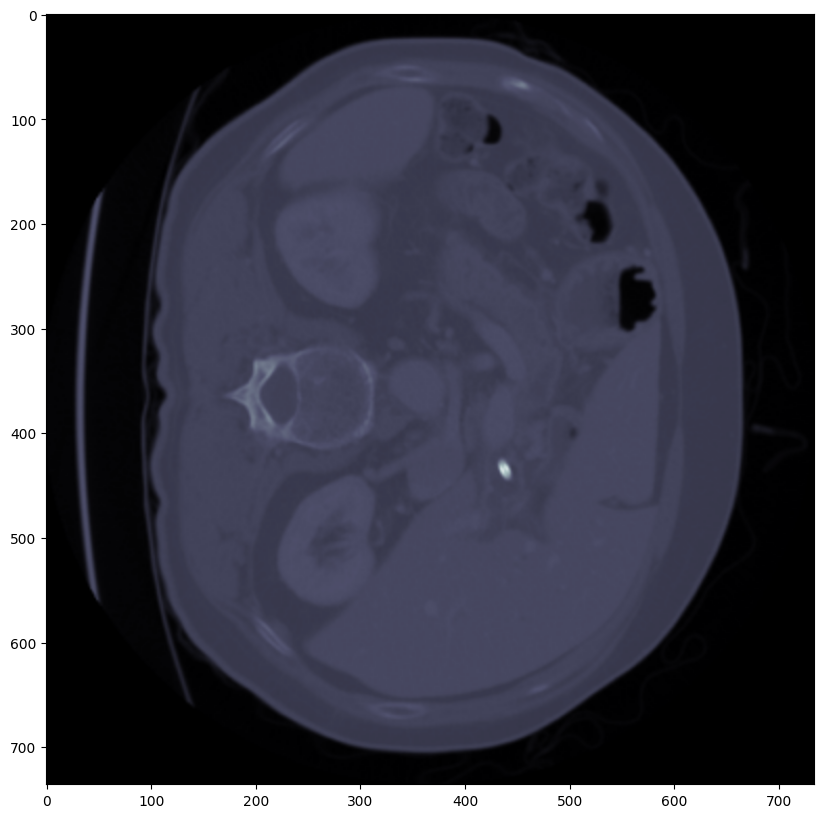

In [10]:
# pancreas image in 'images' folder in this folder
image = Image.open('/content/example_pancreas_ct.png')
image = np.array(image.convert("RGB"))

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

# Selecting objects with Medical-SAM2

In [21]:
%cd ..
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd /content/segment-anything-2
!pip install -e ".[demo]"

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Total 510 (delta 0), reused 0 (delta 0), pack-reused 510 (from 1)
Receiving objects: 100% (510/510), 88.46 MiB | 34.39 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# download all checkpoints of med-sam2
!bash checkpoints/download_ckpts.sh

--2024-09-14 12:13:21--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.121, 18.164.78.72, 18.164.78.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   187MB/s    in 0.8s    

2024-09-14 12:13:21 (187 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2024-09-14 12:13:21--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.121, 18.164.78.72, 18.164.78.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [application/

In [37]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# you can use your fine-tuned model .pt model
# or directly use med-sam2 model
sam2_checkpoint = "/content/segment-anything-2/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [38]:
predictor.set_image(image)

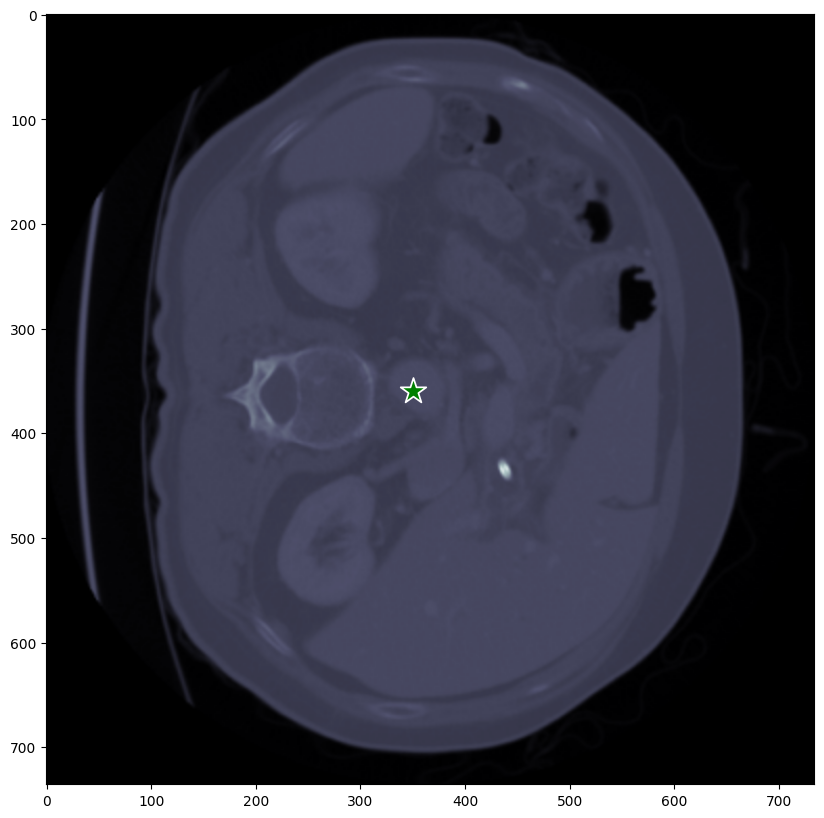

In [43]:
input_point = np.array([[350, 360]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [44]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [45]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [46]:
masks.shape  # (number_of_masks) x H x W

(3, 736, 734)

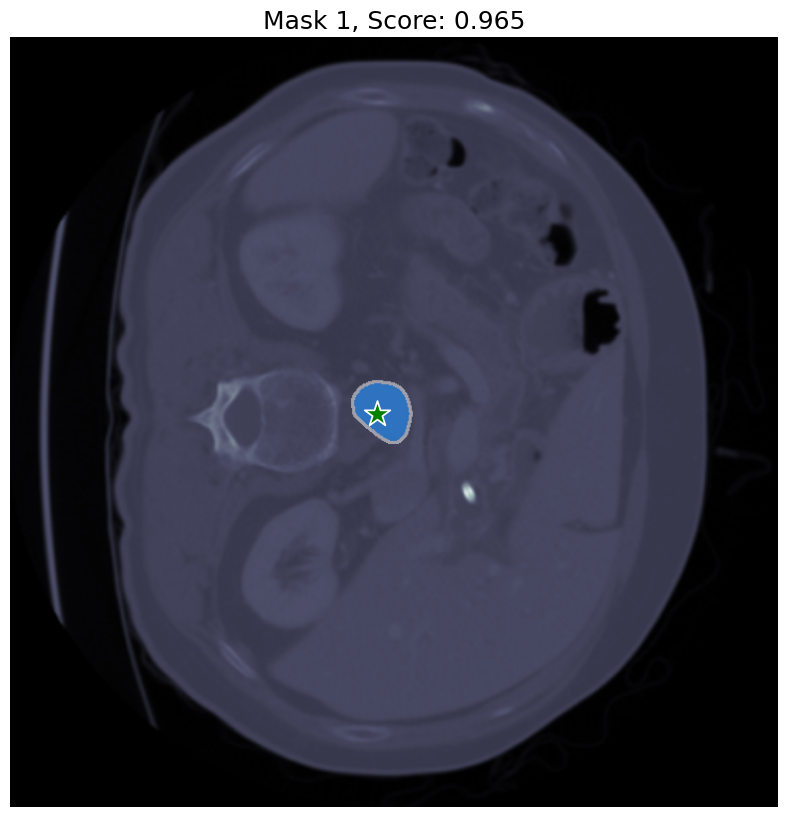

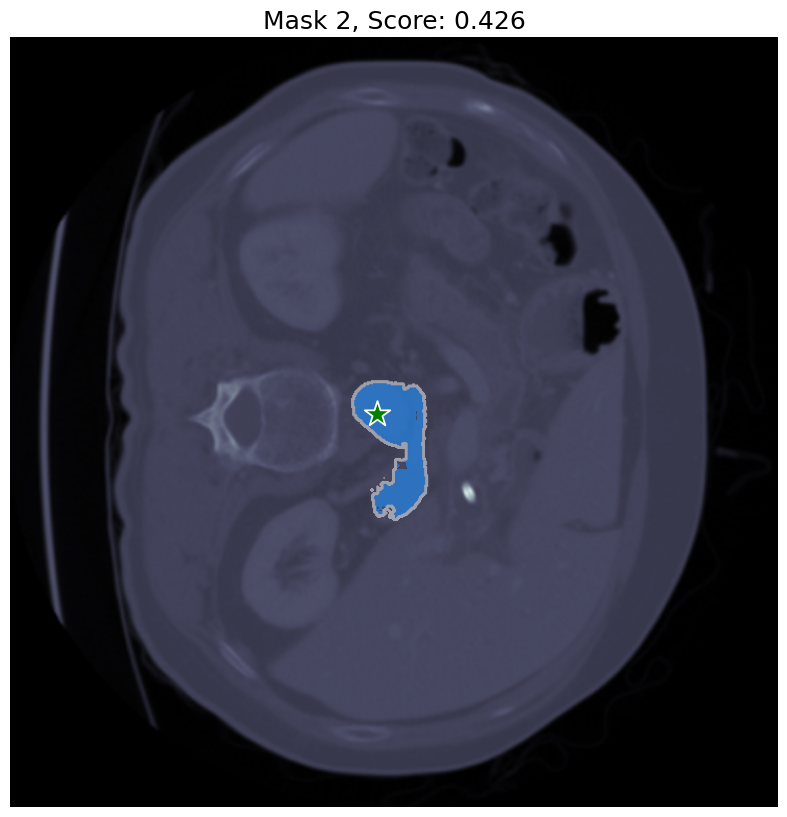

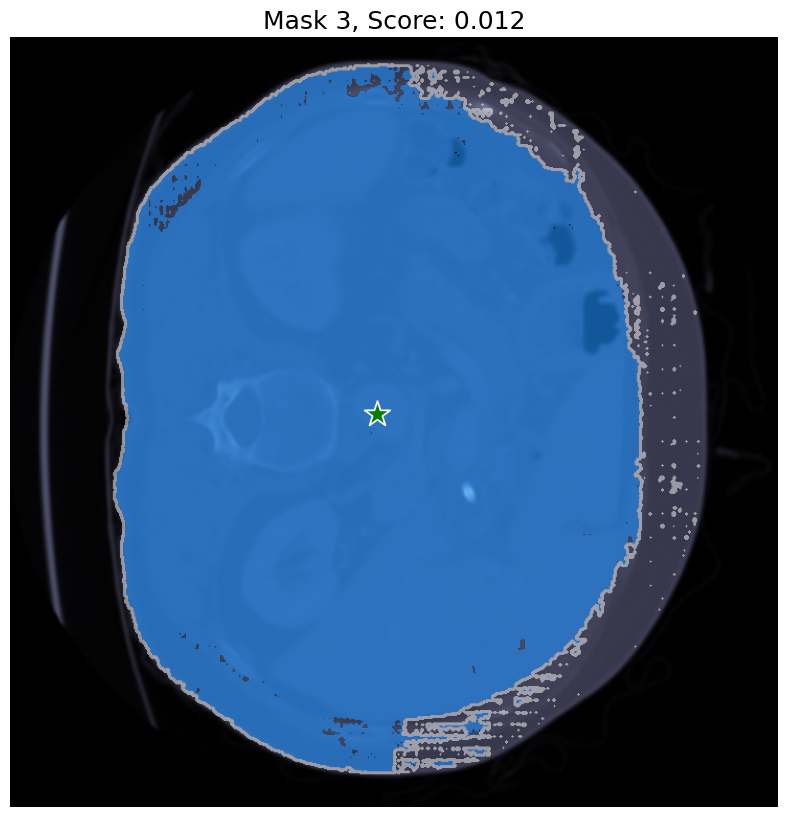

In [47]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

# Specifying a specific object with additional points

In [52]:
input_point = np.array([[500, 375], [300, 240]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [53]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [54]:
masks.shape

(1, 736, 734)

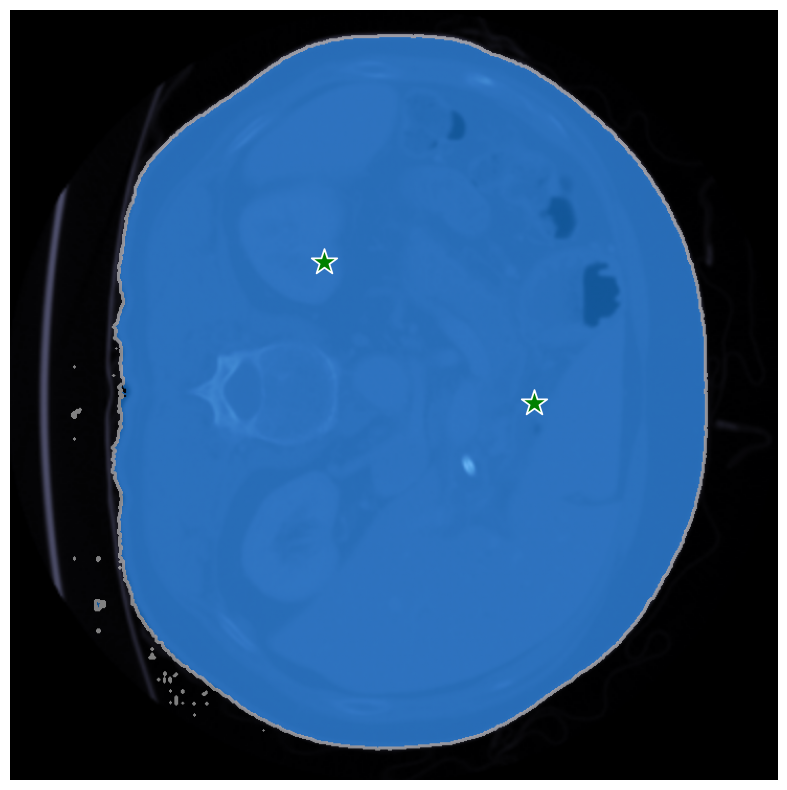

In [55]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

## Excluding Segmentation of a Part

In [83]:
input_point = np.array([[375, 320], [450, 300]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask


In [84]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

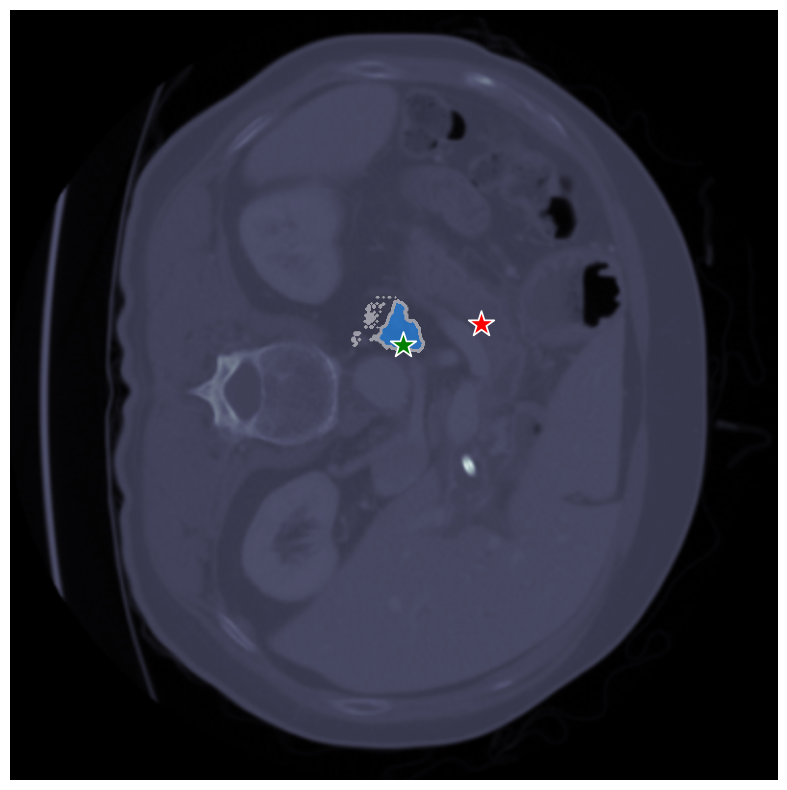

In [85]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

# Specifying a specific object with a box


In [121]:
input_box = np.array([350, 100, 400, 175])

In [122]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

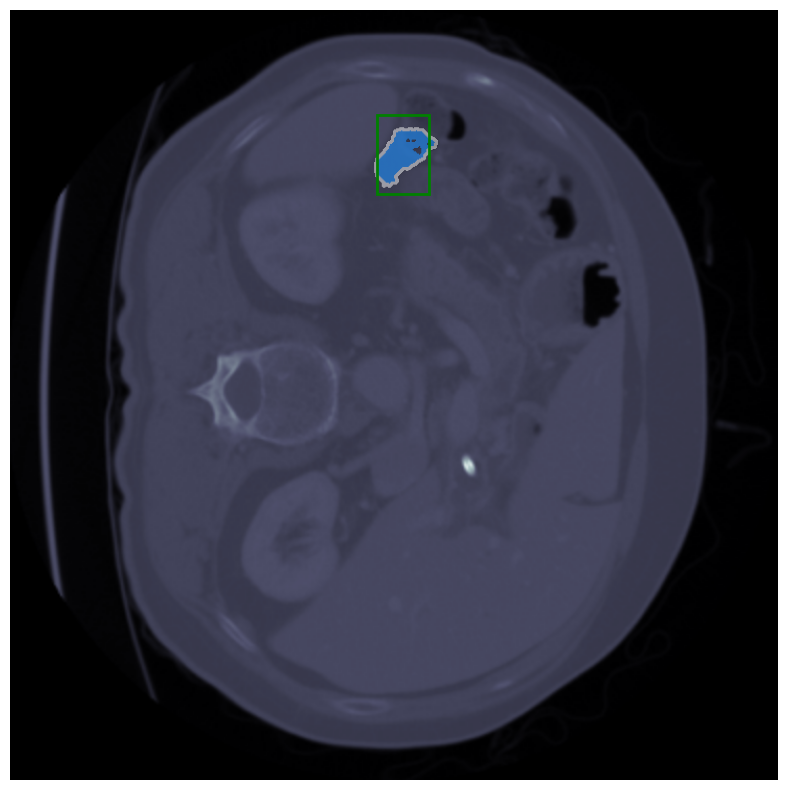

In [123]:
show_masks(image, masks, scores, box_coords=input_box)

# Combining points and boxes

In [130]:
input_box = np.array([350, 100, 400, 475])
input_point = np.array([[375, 320]])
input_label = np.array([0])

In [131]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

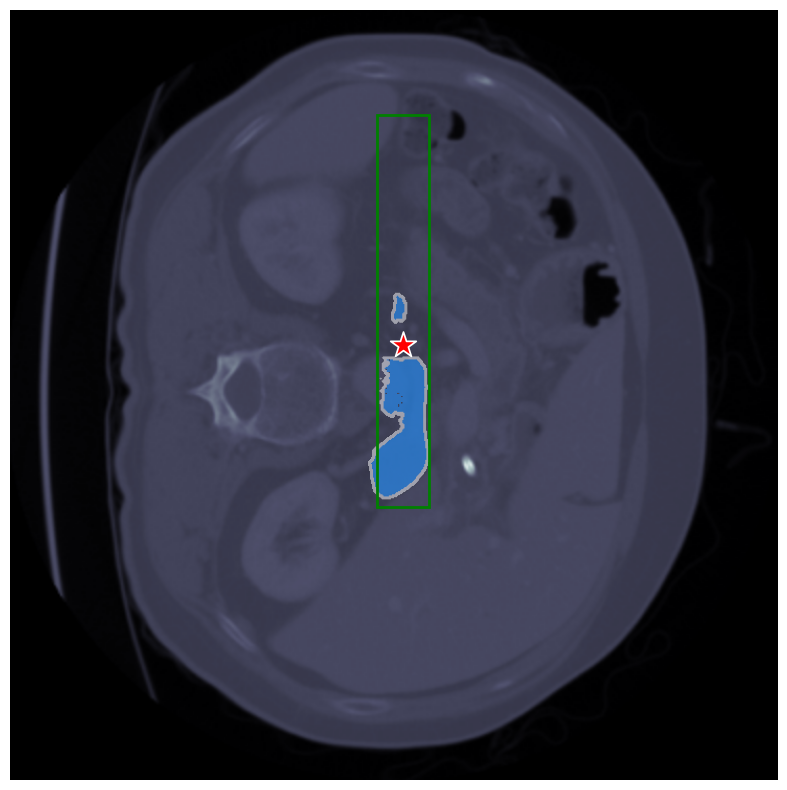

In [132]:
show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

#  Batched prompt inputs

In [143]:
# multiple inputs
input_boxes = np.array([
    [350, 100, 400, 475],
    [150, 370, 300, 450],
    [350, 150, 500, 300],
    [450, 200, 100, 375],
])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [144]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

(4, 1, 736, 734)

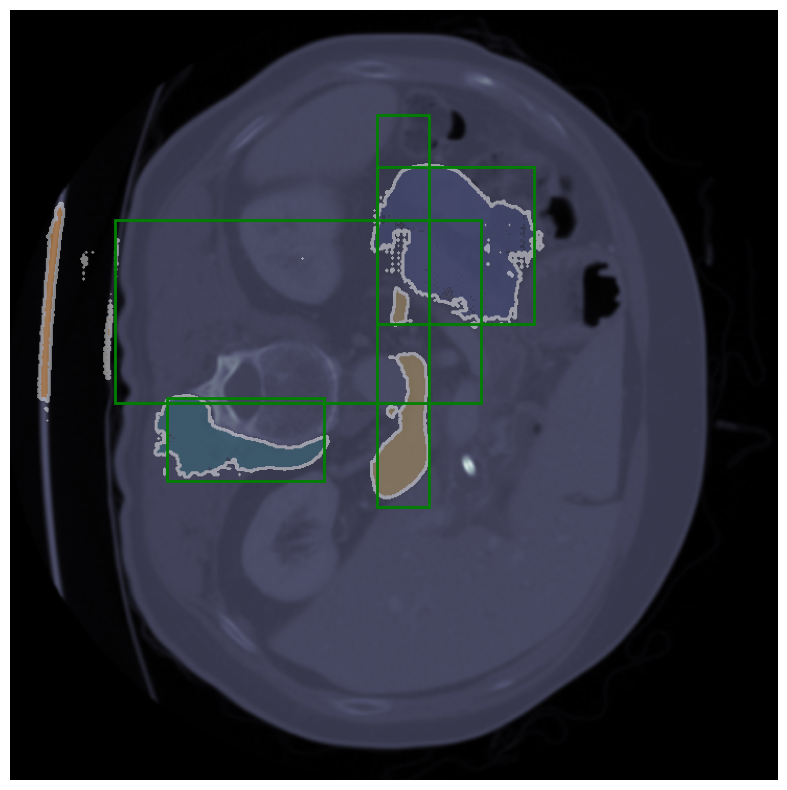

In [145]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()